# Punzi FoM Scans
Now we will test each of our machine learning models to find the optimal probability cut value, more formally the signal probability threshold $p_{thr}$.

## Imports and Constants

In [1]:
import tensorflow as tf
import zfit
from zfit import z
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
from joblib import load
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-04-06 15:59:38.525952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 15:59:38.525983: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


## Loading Data

In [2]:
df = pd.read_csv('../data_files/9.0.1/test.csv', index_col=[0])
X_test = df.drop(['category', 'Lb_M', 'IsSimulated', 'QSQR'], axis=1)
y_test = df.category

## Load Models and Generate Predictions

In [3]:
nn = tf.keras.models.load_model(f'../neural_network/models/v9.0.5')
knn = load(f'../classification_methods/models/KNN_9.0.5_tune.joblib')
rfc = load(f'../classification_methods/models/RFC_9.0.5_tune.joblib')
dtc = load(f'../classification_methods/models/DTC_9.0.5_tune.joblib')
xgb = load(f'../classification_methods/models/XGB_9.0.5.joblib')

models = {'NN': nn, 'KNN': knn, 'RFC': rfc, 'DTC': dtc, 'XGB': xgb}

2022-04-06 15:59:46.341963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-06 15:59:46.342020: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 15:59:46.342058: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eprexb.ph.bham.ac.uk): /proc/driver/nvidia/version does not exist
2022-04-06 15:59:46.342527: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying t

In [4]:
predictions = {}
predictions['NN'] = np.squeeze(nn.predict(X_test))
predictions['KNN'] = knn.predict_proba(X_test)[:,1]
predictions['RFC'] = rfc.predict_proba(X_test)[:,1]
predictions['DTC'] = dtc.predict_proba(X_test)[:,1]
predictions['XGB'] = xgb.predict_proba(X_test)[:,1]

2022-04-06 15:59:48.130013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/user211/envs/scientific/lib64/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/user211/envs/scientific/lib64/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.

## Calculate Punzi FoM

In [5]:
class MyCubic(zfit.pdf.ZPDF):
    _PARAMS = ['p0', 'p1', 'p2', 'p3', 'shift']

    def _unnormalized_pdf(self, x):
       x = z.unstack_x(x)
       p0 = self.params['p0']
       p1 = self.params['p1']
       p2 = self.params['p2']
       p3 = self.params['p3']
       shift = self.params['shift']
       return p3*(x-shift)**3 + p2*(x-shift)**2 + p1*(x-shift) + p0

def CubicIntegral(limits, params, model):
   (lower,), (upper,) = limits.limits
   p1 = params['p1']
   p2 = params['p2']
   p3 = params['p3']
   shift = params['shift']
   return (3*p3*(upper-shift)**2 + 2*p2*upper) - (3*p3*(lower-shift)**2 + 2*p2*lower)

# Register the integrals
limits = zfit.Space.from_axes(axes=0, limits=(zfit.Space.ANY_LOWER, zfit.Space.ANY_UPPER))
MyCubic.register_analytic_integral(func=CubicIntegral, limits=limits)

def fitCub(np_data, label, param_ranges, mass_ranges=[4600, 5200, 5800, 6400]):
    lowerSB = zfit.Space("Lb_M",(mass_ranges[0],mass_ranges[1]))
    upperSB = zfit.Space("Lb_M",(mass_ranges[2],mass_ranges[3]))
    massSbSpace = lowerSB + upperSB
    
    LbM = zfit.Data.from_numpy(obs=massSbSpace, array=np_data)
    
    p3 = zfit.Parameter('p3_%s'%label, -1.1515201462719907e-09, 0, 0.1)
    p2 = zfit.Parameter('p2_%s'%label, 1.407709468111769e-05, 0, 0.1)
    p1 = zfit.Parameter('p1_%s'%label, -0.2944208228095719, -0.4, 0)
    p0 = zfit.Parameter('p0_%s'%label, 292.63288141511055, 280, 300)
    shift = zfit.Parameter('shift_%s'%label, 5763.025336526583, 5700, 5800)
    
    cubic = MyCubic(obs=massSbSpace, p0=p0, p1=p1, p2=p2, p3=p3, shift=shift)
    
    cubic_yield = zfit.Parameter('yield_%s'%label, *param_ranges, step_size=1)
    cubic_ext = cubic.create_extended(cubic_yield)
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(cubic_ext, LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb, params=[cubic_yield])
    # Only allow floating of the yield
    
    return cubic_ext, fitResult, LbM

def fitDoubleCB(np_data, label, mass_ranges=[4600, 6400], param_ranges=[17000, 0, 100000]):
    massObsMC = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    MC_LbM = zfit.Data.from_numpy(obs=massObsMC, array=np_data)
    
    mu_CB = zfit.Parameter('mu_CB_%s'%label, 5612, 5590, 5640)
    sigma_CB = zfit.Parameter('sigma_CB_%s'%label, 21.99, 20, 23)
    alpha_l = zfit.Parameter('alpha_l_%s'%label, 0.4656, 0, 0.7)
    n_l = zfit.Parameter('n_l_%s'%label, 2.869, 2, 3.2)
    alpha_r = zfit.Parameter('alpha_r_%s'%label, 1.219, 1, 2)
    n_r = zfit.Parameter('n_r_%s'%label, 1.896, 1, 2)
    
    dcb = zfit.pdf.DoubleCB(obs=massObsMC, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, nl=n_l, alphar=alpha_r, nr=n_r)
    
    dcb_yield = zfit.Parameter('yield_%s'%label, *param_ranges, step_size=1)
    dcb_ext = dcb.create_extended(dcb_yield)
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(dcb_ext, MC_LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb, params=[mu_CB, sigma_CB, dcb_yield])
    
    return dcb_ext, fitResult, MC_LbM

In [9]:
def get_punzi(df, pthrs, label, a=5, cut_dir='gt'):
    """
    
    DataFrame has columns of:
        correct labels | Lb_M | probability
        
    """
    
    punzis = []
    n_signal_before = np.count_nonzero(df['category'].to_numpy())
    
    for i, pthr in enumerate(pthrs):
        # Iterate through each threshold probability
        pred_class = np.where(df['Probability'].to_numpy() > pthr, 1, 0).flatten()
        df["PredClass"] = pred_class
        
        effs = np.count_nonzero(np.logical_and(pred_class==1, df['category'].to_numpy()==1)) / n_signal_before
        
        DCBMod, DCBResult, DCBTensor = fitDoubleCB(df['Lb_M'][np.logical_and(df["PredClass"]==1, df["category"]==1)].to_numpy(), f"DCB_{label}_{i}")
        expMod, expResult, expTensor = fitCub(df['Lb_M'][np.logical_and(df["PredClass"]==1, df["category"]==0)].to_numpy(), f"BG_{label}_{i}", [10000, 1, 19000])
        
        BGInterpRange = np.ones(2)*DCBResult.params[f"mu_CB_DCB_{label}_{i}"]['value']+np.array([-1*a, a])*DCBResult.params[f"sigma_CB_DCB_{label}_{i}"]['value']
        BGInterpVal=expMod.integrate(limits=BGInterpRange, norm_range=expMod.norm_range)*expResult.params[f"yield_BG_{label}_{i}"]["value"]
        
        punzi = effs / (a/2 + np.sqrt(BGInterpVal[0]))
        punzis.append(punzi)
    
    return np.array(punzis)

In [7]:
MODEL = 'NN'
subdf = df[['category', 'Lb_M']].copy()
probs = np.linspace(0.2, 0.95, 50)

In [10]:
subdf['Probability'] = predictions[MODEL]

punzi_nn = get_punzi(subdf, probs, 'NN')

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/core/integration.py:499: UserWarning: Multispace limits compare never equal to Space.
  if integ.limits >= limits


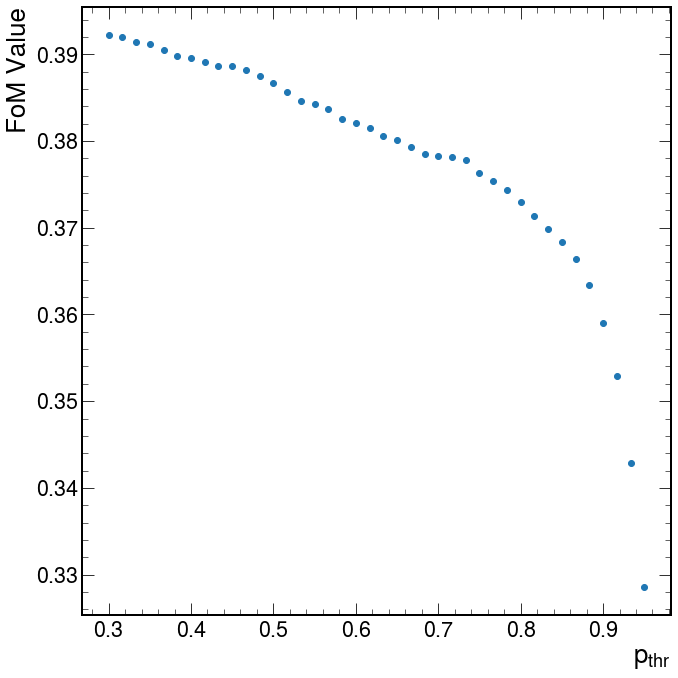

In [13]:
plt.scatter(probs, punzi_nn)
plt.xlabel(r'$p_{thr}$')
plt.ylabel('FoM Value')
plt.tight_layout()
plt.show()